In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/fire_dataset.zip'

Archive:  /content/fire_dataset.zip
   creating: fire_dataset/fire_images/
  inflating: fire_dataset/fire_images/1.png  
  inflating: fire_dataset/fire_images/132343342_21n.jpg  
  inflating: fire_dataset/fire_images/14.jpg  
  inflating: fire_dataset/fire_images/2.png  
  inflating: fire_dataset/fire_images/20130611_100618_Black-Forest-Fire-engulfs-house.jpg  
  inflating: fire_dataset/fire_images/3.png  
  inflating: fire_dataset/fire_images/4.png  
  inflating: fire_dataset/fire_images/5.png  
  inflating: fire_dataset/fire_images/6.png  
  inflating: fire_dataset/fire_images/7.png  
  inflating: fire_dataset/fire_images/800px-Fires_cross_a_hill_in_SoCal_October_2007.jpg  
  inflating: fire_dataset/fire_images/9.png  
  inflating: fire_dataset/fire_images/a.jpg  
  inflating: fire_dataset/fire_images/aggiecrk-wildfire-07072015-usfs-580.jpg  
  inflating: fire_dataset/fire_images/b.jpg  
  inflating: fire_dataset/fire_images/bcws-carousel-2.jpg  
  inflating: fire_dataset/fire_images

In [ ]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image

In [ ]:
# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
# System libraries
from pathlib import Path
import os.path

In [ ]:
# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Create Helper Functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-10-26 20:54:55--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-10-26 20:54:55 (50.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

# Load & Transform The Data

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (320, 320)

In [ ]:
# Walk through each directory
dataset = "/content/fire_dataset"
walk_through_dir(dataset)

There are 2 directories and 0 images in '/content/fire_dataset'.
There are 0 directories and 1857 images in '/content/fire_dataset/fire_images'.
There are 0 directories and 244 images in '/content/fire_dataset/non_fire_images'.


# Placing data into a Dataframe

The first column <b>filepaths</b> contains the file path location of each individual images.<br> The second column <b>labels</b>, on the other hand, contains the class label of the corresponding image from the file path

In [ ]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)
len(list(image_dir.glob(r'**/*.png')))

2057

In [ ]:
len(list(image_dir.glob(r'**/*.png')))

2057

In [ ]:
image_df

,Filepath,Label
0,/content/fire_dataset/fire_images/hhh.jpg,fire_images
1,/content/fire_dataset/fire_images/t.jpg,fire_images
2,/content/fire_dataset/fire_images/canada-wildf...,fire_images
3,/content/fire_dataset/fire_images/zz.jpg,fire_images
4,/content/fire_dataset/fire_images/Chimney-Fire...,fire_images
...,...,...
2096,/content/fire_dataset/non_fire_images/non_fire...,non_fire_images
2097,/content/fire_dataset/non_fire_images/non_fire...,non_fire_images
2098,/content/fire_dataset/non_fire_images/non_fire...,non_fire_images
2099,/content/fire_dataset/non_fire_images/non_fire...,non_fire_images


# Visualizing images from the dataset

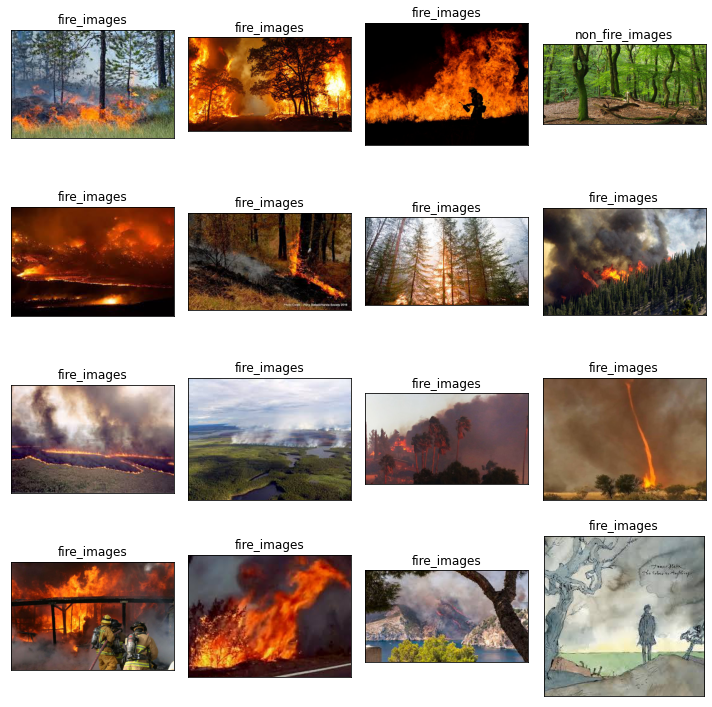

In [ ]:
import matplotlib.image as mpimg
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(image_df.Filepath[random_index[i]])
    ax.imshow(image)
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# Data Preprocessing

The data will be split into three different categories: <b>Training, Validation and Testing.</b> <br>The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data.<br> Finally, the performance of the data will be evaluated using the test data(data the model has not previously seen).

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

**Split the data into three categories.**

**Training Images**

In [ ]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

Found 1344 validated image filenames belonging to 2 classes.


**Validation Images**

In [ ]:
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 336 validated image filenames belonging to 2 classes.


**Test Images**

In [ ]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 421 validated image filenames belonging to 2 classes.


In [ ]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

**Training the model**

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Create checkpoint callback
checkpoint_path = "fires_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [ ]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "fire_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/fire_classification/20221026-212421
Epoch 1/100
42/42 [==============================] - 87s 2s/step - loss: 0.2008 - accuracy: 0.9189 - val_loss: 0.0964 - val_accuracy: 0.9613
Epoch 2/100
42/42 [==============================] - 82s 2s/step - loss: 0.0740 - accuracy: 0.9725 - val_loss: 0.0625 - val_accuracy: 0.9821
Epoch 3/100
42/42 [==============================] - 74s 2s/step - loss: 0.0534 - accuracy: 0.9836 - val_loss: 0.0523 - val_accuracy: 0.9881
Epoch 4/100
42/42 [==============================] - 83s 2s/step - loss: 0.0351 - accuracy: 0.9896 - val_loss: 0.0535 - val_accuracy: 0.9851
Epoch 5/100
42/42 [==============================] - 81s 2s/step - loss: 0.0301 - accuracy: 0.9888 - val_loss: 0.0491 - val_accuracy: 0.9881
Epoch 6/100
42/42 [==============================] - 90s 2s/step - loss: 0.0228 - accuracy: 0.9948 - val_loss: 0.0483 - val_accuracy: 0.9881
Epoch 7/100
42/42 [==============================] - 85s 2s/step - loss

# **Model Evaluation**

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.06560
Test Accuracy: 98.34%


**Visualizing loss curves**

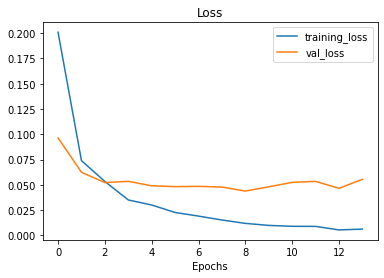

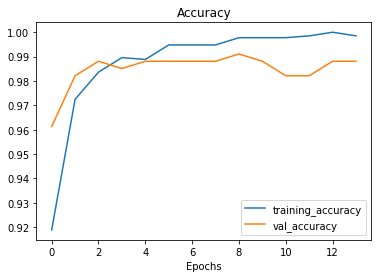

In [ ]:
plot_loss_curves(history)

<b>Making predictions on the Test Data

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

14/14 [==============================] - 19s 1s/step
The first 5 predictions: ['non_fire_images', 'fire_images', 'fire_images', 'fire_images', 'non_fire_images']


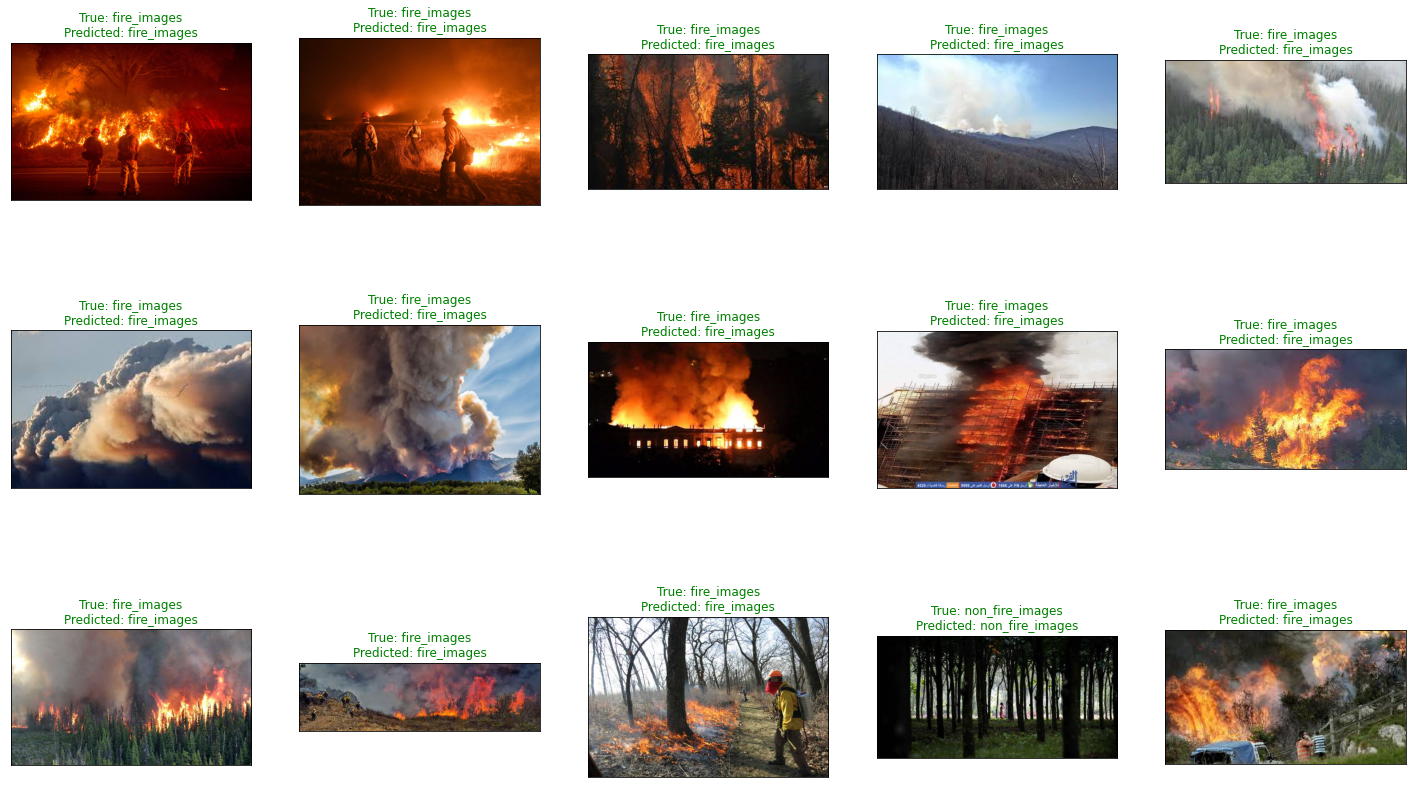

<Figure size 432x288 with 0 Axes>

In [ ]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(test_df.Filepath.iloc[random_index[i]])
    ax.imshow(image)
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

<b>Plotting the Classification Reports and Confusion Matrix

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                 precision    recall  f1-score   support

    fire_images       0.99      0.99      0.99       370
non_fire_images       0.94      0.92      0.93        51

       accuracy                           0.98       421
      macro avg       0.96      0.96      0.96       421
   weighted avg       0.98      0.98      0.98       421



In [ ]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
fire_images,0.989218,0.991892,0.990553,370.000000
non_fire_images,0.940000,0.921569,0.930693,51.000000
accuracy,0.983373,0.983373,0.983373,0.983373
macro avg,0.964609,0.956730,0.960623,421.000000
weighted avg,0.983256,0.983373,0.983302,421.000000


In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")


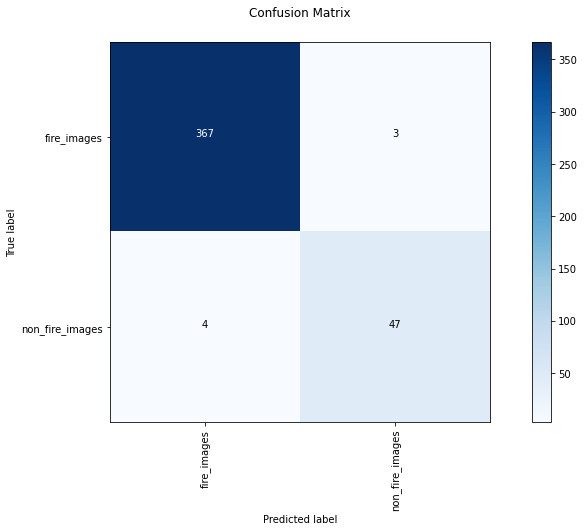

In [ ]:
make_confusion_matrix(y_test, pred, list(labels.values()))